In [3]:
using ZipFile, Distributed, CSV, DataFrames, Random, StatsBase, Plots, Statistics, StableRNGs, MLJBase
using Flux
using Flux: logitbinarycrossentropy
using BSON: @save
using Distributions

file = CSV.read("train.csv", DataFrame)

,battery_power,blue,clock_speed,dual_sim,fc,four_g,int_memory,m_dep
,Int64,Int64,Float64,Int64,Int64,Int64,Int64,Float64
1,842,0,2.2,0,1,0,7,0.6
2,1021,1,0.5,1,0,1,53,0.7
3,563,1,0.5,1,2,1,41,0.9
4,615,1,2.5,0,0,0,10,0.8
5,1821,1,1.2,0,13,1,44,0.6
6,1859,0,0.5,1,3,0,22,0.7
7,1821,0,1.7,0,4,1,10,0.8
8,1954,0,0.5,1,0,0,24,0.8
9,1445,1,0.5,0,0,0,53,0.7


In [4]:
# Transfer DataFrame to matrix form
df = file |> Tables.matrix

# Transfer the dataset to 2-classifiers. df_0 represents the result is 0, df_1 represents the result is 1.
# Due to my datasset is binary problems, and each result is 50 percents of the whole dataset. So i didn't add any other pre-actions for dataset. 

mat_0 = df[df[:,21] .<= 1, :]
mat_1 = df[df[:,21] .>= 2, :]


1000×21 Matrix{Float64}:
 1021.0  1.0  0.5  1.0   0.0  1.0  53.0  …   3.0   7.0  1.0  1.0  0.0  2.0
  563.0  1.0  0.5  1.0   2.0  1.0  41.0      2.0   9.0  1.0  1.0  0.0  2.0
  615.0  1.0  2.5  0.0   0.0  0.0  10.0      8.0  11.0  1.0  0.0  0.0  2.0
 1821.0  0.0  1.7  0.0   4.0  1.0  10.0      8.0  18.0  1.0  0.0  1.0  3.0
  769.0  1.0  2.9  1.0   0.0  0.0   9.0      2.0   7.0  0.0  0.0  0.0  3.0
 1520.0  1.0  2.2  0.0   5.0  1.0  33.0  …   9.0  13.0  1.0  1.0  1.0  3.0
  803.0  1.0  2.1  0.0   7.0  0.0  17.0      1.0   4.0  1.0  0.0  1.0  2.0
  838.0  0.0  0.5  0.0   1.0  1.0  13.0      9.0  19.0  1.0  0.0  1.0  3.0
  595.0  0.0  0.9  1.0   7.0  1.0  23.0      2.0  18.0  1.0  1.0  0.0  3.0
  772.0  0.0  1.1  1.0  12.0  0.0  39.0     15.0   3.0  1.0  1.0  0.0  3.0
 1709.0  1.0  2.1  0.0   1.0  0.0  13.0  …   1.0  15.0  1.0  0.0  0.0  3.0
  961.0  1.0  1.4  1.0   0.0  1.0  57.0      9.0   7.0  1.0  1.0  1.0  2.0
  519.0  1.0  1.6  1.0   7.0  1.0  51.0      1.0   4.0  1.0  0.0  1.0  3.0


In [5]:
# randomly select 70% data from data set as the train data

train_data = randsubseq(1:1000, 0.7)
train_df = vcat(mat_0[train_data, :], mat_1[train_data, :])

# select the rest as the test data 

test_data = [i for i in 1:1000 if isempty(searchsorted(train_data, i))]
test_df = vcat(mat_0[test_data, :], mat_1[test_data, :])

628×21 Matrix{Float64}:
  842.0  0.0  2.2  0.0   1.0  0.0   7.0  …   7.0  19.0  0.0  0.0  1.0  1.0
 1954.0  0.0  0.5  1.0   0.0  0.0  24.0      3.0   5.0  1.0  1.0  1.0  0.0
  509.0  1.0  0.6  1.0   2.0  1.0   9.0     10.0  12.0  1.0  0.0  0.0  0.0
 1866.0  0.0  0.5  0.0  13.0  1.0  52.0      9.0   3.0  1.0  0.0  1.0  0.0
  682.0  1.0  0.5  0.0   4.0  0.0  19.0      1.0  18.0  0.0  1.0  1.0  1.0
 1949.0  0.0  2.6  1.0   4.0  0.0  47.0  …   5.0  20.0  0.0  0.0  1.0  1.0
 1602.0  1.0  2.8  1.0   4.0  1.0  38.0      7.0  20.0  1.0  0.0  0.0  0.0
 1568.0  1.0  0.5  0.0  16.0  0.0  33.0      1.0   6.0  1.0  1.0  1.0  0.0
  644.0  1.0  2.7  0.0   0.0  0.0  22.0      1.0  15.0  1.0  0.0  0.0  0.0
  725.0  0.0  1.3  1.0  16.0  0.0  60.0      4.0  15.0  1.0  0.0  0.0  1.0
 1656.0  0.0  1.0  0.0   5.0  1.0  34.0  …  12.0  14.0  1.0  1.0  0.0  1.0
 1054.0  1.0  1.8  1.0   3.0  1.0  40.0     12.0  12.0  1.0  0.0  1.0  1.0
  578.0  1.0  2.6  1.0   2.0  1.0  57.0      3.0   5.0  1.0  0.0  1.0  0.0
 

In [6]:
# parameters of the training and testing data
para_train = train_df[:, 1:20]
para_test = test_df[:, 1:20]

# value is never used?
value_train = train_df[:, 21]
value_test = test_df[:, 21]
value_train_std = reshape(value_train, (1, :)) 
value_test_std = reshape(value_test, (1, :)) 


1×628 Matrix{Float64}:
 1.0  0.0  0.0  0.0  1.0  1.0  0.0  0.0  …  3.0  3.0  2.0  2.0  2.0  2.0  3.0

In [7]:
dt = StatsBase.fit(ZScoreTransform, para_train, dims=1)

# rotate the matrix for 90 degree
para_train_std = StatsBase.transform(dt, para_train)
para_test_std = StatsBase.transform(dt, para_test)

para_train_std = transpose(para_train_std) 
para_test_std = transpose(para_test_std)

20×628 transpose(::Matrix{Float64}) with eltype Float64:
 -0.889597   1.63079   -1.64435   …   0.327533   1.24548     0.526988
 -1.01136   -1.01136    0.988045     -1.01136   -1.01136     0.988045
  0.845458  -1.23071   -1.10858      -0.497946   0.112692   -1.23071
 -0.998179   1.00109    1.00109       1.00109   -0.998179   -0.998179
 -0.76351   -0.991483  -0.535537     -0.76351   -0.0795911  -0.991483
 -1.04283   -1.04283    0.958233  …   0.958233  -1.04283    -1.04283
 -1.39836   -0.458762  -1.28782      -0.790386   0.480838   -0.790386
  0.359258   1.05105   -1.37022      -1.02433   -0.332535    0.359258
  1.35565    1.32744   -1.32448      -0.30885    0.678566   -0.506334
 -1.09231   -0.214367   0.224605     -1.09231    0.663577    0.224605
 -1.29714   -1.62514    0.8348    …   0.998796   1.65478    -1.62514
 -1.4395    -0.340306   1.05603       0.388024  -0.12136     0.499731
 -1.20528   -0.281232  -0.104888     -0.901965   0.39593    -0.398795
  0.389475  -1.33142   -1.50546     

In [8]:
# basic parameters
batch_size = 20
population_size = 300
Mutation_rate = 0.5
Crossover_rate = 0.4
Retain_rate = 0.9
iteration = 500
layer = 2

2

In [9]:
#build the models with sigmoid as Activation Function

function sigmoidModel(batch_size)
    model = Chain(Dense(batch_size, 12, relu), Dense(12, 1, relu))
    return model
end

sigmoidModel (generic function with 1 method)

In [10]:
# We will define a function that can generate initial weight and bias for the neutral network.

function generateInitialPopulation(initial_population_size)
    chromosomes = []
    for i in 1 : initial_population_size
        chromosome = sigmoidModel(batch_size)
        push!(chromosomes, chromosome)
    end
    return chromosomes
end

generateInitialPopulation (generic function with 1 method)

In [11]:
# Do we need to train the network?


function trainNetwork(chromosomes)
    model_mean_acc_list = []
    i=1

    for model in chromosomes
        push!(model_mean_acc_list, mean(accuracy(para_train_std, value_train_std, i)))
        i = i + 1
    end
    
    index = reverse(sortperm(model_mean_acc_list))
    model_mean_acc_list = model_mean_acc_list[index]
    chromosome = chromosomes[index]
    
    return chromosome, model_mean_acc_list
end

trainNetwork (generic function with 1 method)

In [12]:
# why there is no manipuation on test data?
function testModel(model_index)
    model_acc_list=[]
    return mean(accuracy(para_test_std, value_test_std, model_index))
end

testModel (generic function with 1 method)

In [13]:
# create a new model using two parent models

function crossover(parent_one_chromosome,parent_two_chromosome)
    n_offspring = deepcopy(parent_one_chromosome)
    for i in 1:layer
        select_one_layer = shuffle(collect(1:layer))[1]
        mother_bias=parent_two_chromosome[select_one_layer].bias
        row_to_shuffle = shuffle(collect(1:size(mother_bias)[1]))[1]
        if rand() < Crossover_rate
            n_offspring[select_one_layer].bias[row_to_shuffle]=mother_bias[row_to_shuffle]
        end
    end
    
    for i in 1:layer
        select_one_layer=shuffle(collect(1:layer))[1]
        mother_weight=parent_two_chromosome[select_one_layer].weight
        row_to_shuffle=shuffle(collect(1:size(mother_weight)[1]))[1]
        col_to_shuffle=shuffle(collect(1:size(mother_weight)[2]))[1]
        if rand() < Crossover_rate
            n_offspring[select_one_layer].weight[row_to_shuffle,col_to_shuffle]=mother_weight[row_to_shuffle,col_to_shuffle]
        end
    end
    return n_offspring
end

crossover (generic function with 1 method)

In [14]:
#Do mutation here
function mutation(offspring)
    n_offspring = deepcopy(offspring)
    for i in 1:layer
        select_one_layer = shuffle(collect(1:layer))[1]
        bias = offspring[select_one_layer].bias
        row_to_shuffle = shuffle(collect(1:size(bias)[1]))[1]
        if rand() < Mutation_rate
            n_offspring[select_one_layer].bias[row_to_shuffle] += rand(Uniform(-0.5,0.5),1)[1]
        end
    end
    
    for i in 1:layer
        select_one_layer = shuffle(collect(1:layer))[1]
        weight = n_offspring[select_one_layer].weight
        row_to_shuffle = shuffle(collect(1:size(weight)[1]))[1]
        col_to_shuffle = shuffle(collect(1:size(weight)[2]))[1]
        if rand() < Mutation_rate
            n_offspring[select_one_layer].weight[row_to_shuffle,col_to_shuffle] += rand(Uniform(-0.5,0.5),1)[1]
        end
    end
    return n_offspring
end

mutation (generic function with 1 method)

In [15]:
chromosomes = generateInitialPopulation(population_size)

300-element Vector{Any}:
 Chain(Dense(20, 12, relu), Dense(12, 1, relu))  # 265 parameters
 Chain(Dense(20, 12, relu), Dense(12, 1, relu))  # 265 parameters
 Chain(Dense(20, 12, relu), Dense(12, 1, relu))  # 265 parameters
 Chain(Dense(20, 12, relu), Dense(12, 1, relu))  # 265 parameters
 Chain(Dense(20, 12, relu), Dense(12, 1, relu))  # 265 parameters
 Chain(Dense(20, 12, relu), Dense(12, 1, relu))  # 265 parameters
 Chain(Dense(20, 12, relu), Dense(12, 1, relu))  # 265 parameters
 Chain(Dense(20, 12, relu), Dense(12, 1, relu))  # 265 parameters
 Chain(Dense(20, 12, relu), Dense(12, 1, relu))  # 265 parameters
 Chain(Dense(20, 12, relu), Dense(12, 1, relu))  # 265 parameters
 Chain(Dense(20, 12, relu), Dense(12, 1, relu))  # 265 parameters
 Chain(Dense(20, 12, relu), Dense(12, 1, relu))  # 265 parameters
 Chain(Dense(20, 12, relu), Dense(12, 1, relu))  # 265 parameters
 ⋮
 Chain(Dense(20, 12, relu), Dense(12, 1, relu))  # 265 parameters
 Chain(Dense(20, 12, relu), Dense(12, 1, relu)) 

In [16]:
train_acc_list = []
test_acc_list = []

Any[]

In [17]:

# println("\nTrial") 
accuracy(para, val, i) = mean(vec(chromosomes[i](para) .> 0.5) .== val)

model,score = trainNetwork(chromosomes)
# println("\nTrial") 
#erase models with low accuracy
# println(typeof(size(chromosomes)[1] * Retain_rate)) 
# println(typeof())
chromosomes = chromosomes[1 : floor(Int ,size(chromosomes)[1] * Retain_rate)]
# println("\nTrial") 
test_acc=testModel(1)
# println("\nTrial") 
append!(train_acc_list,mean(score))
append!(test_acc_list,test_acc)

# println("\nTrial") 

for i in 1 : 7
    println(accuracy(para_train_std, value_train_std, i))
end

while size(chromosomes)[1] < population_size
    # select a chromosome to do crossover
    model_mean_acc_list = []
    i=1
    for chromosome in chromosomes
        append!(model_mean_acc_list,mean(accuracy(para_train_std,value_train_std,i)))
        i=i+1
    end

    idx=collect(1:size(chromosomes)[1])
    idx=shuffle(idx)
    parent_one_chromosome=chromosomes[idx[1]]
    parent_two_chromosome=chromosomes[idx[2]]

    offspring = crossover(parent_one_chromosome,parent_two_chromosome)
    offspring = mutation(offspring)
    append!(chromosomes,[offspring])
end
println("new")
for j in 1:7
    println(accuracy(para_train_std, value_train_std,j))
end 

0.2489906416544127
0.24992775119210534
0.24961750631114588
0.24893751753096074
0.24926263716648675
0.2488822684425707
0.25004674922863773
new
0.2489906416544127
0.24992775119210534
0.24961750631114588
0.24893751753096074
0.24926263716648675
0.2488822684425707
0.25004674922863773


In [18]:
# to do the test
test=[]

for j in 1:30
    push!(test,accuracy(para_train_std, value_train_std,j))
end

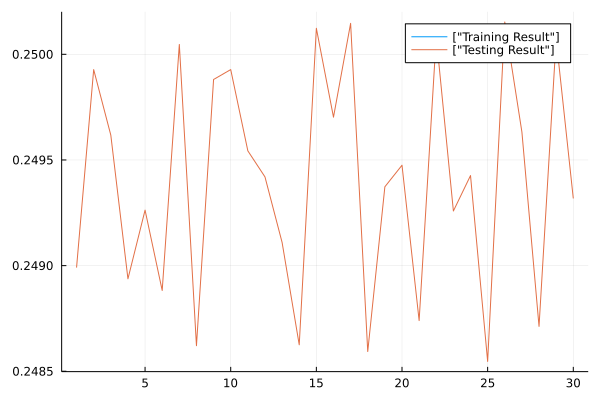

In [19]:
Plots.plot(train_acc_list,label=["Training Result"])
Plots.plot!(test,label=["Testing Result"])

In [20]:
"""
    In order to compute for confusion matrix
"""
#TT
TT = sum(vec(chromosomes[1](para_test_std) .> 0.5) .== 1)
#TF
TF = sum(vec(chromosomes[1](para_test_std) .> 0.5) .== 0)
#FT
FT = sum(vec(chromosomes[1](para_test_std) .< 0.5) .== 1)
#FF
FF = sum(vec(chromosomes[1](para_test_std) .< 0.5) .== 0)
println("confusion matrix:")
println("True True Result: $TT,  True False Result: $TF")
println("False False Result: $FF,   False True Result: FT")

confusion matrix:
True True Result: 101,  True False Result: 527
False False Result: 101,   False True Result: FT
